In [69]:
import pandas as pd
import numpy as np

In [70]:
data = pd.read_csv('Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [71]:
data.shape

(232074, 3)

In [72]:
data['text'] = data['text'].str.lower()
data['text'] = data['text'].replace(r'[^a-z0-9\s]', '', regex=True)
data['text']

0         ex wife threatening suiciderecently i left my ...
1         am i weird i dont get affected by compliments ...
2         finally 2020 is almost over so i can never hea...
3                 i need helpjust help me im crying so hard
4         im so losthello my name is adam 16 and ive bee...
                                ...                        
232069    if you dont like rock then your not going to g...
232070    you how you can tell i have so many friends an...
232071    pee probably tastes like salty tea can someone...
232072    the usual stuff you find hereim not posting th...
232073    i still havent beaten the first boss in hollow...
Name: text, Length: 232074, dtype: object

In [73]:
data.dtypes

Unnamed: 0     int64
text          object
class         object
dtype: object

In [74]:
data['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

In [75]:
df = data[['text', 'class']]
df.shape

(232074, 2)

In [76]:
df['class_val'] = df['class'].apply(lambda x:1 if x=='suicide' else 0)
df.shape

(232074, 3)

In [77]:
df.head()

,text,class,class_val
0,ex wife threatening suiciderecently i left my ...,suicide,1
1,am i weird i dont get affected by compliments ...,non-suicide,0
2,finally 2020 is almost over so i can never hea...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,im so losthello my name is adam 16 and ive bee...,suicide,1


In [78]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

In [79]:
max_features = 5000
max_length = 200

tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(df['text'])
X = pad_sequences(tokenizer.texts_to_sequences(df['text']), maxlen= max_length)
y = df['class_val'].values

In [80]:
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [83]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=16, input_length=max_length, input_shape=(max_length,)))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 200, 16)        │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,801 (393.75 KB)

 Trainable params: 100,801 (393.75 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
history = model.fit(X_train, y_train, epochs=2, batch_size = 64, validation_split=0.2)

Epoch 1/5
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 142s 61ms/step - accuracy: 0.9076 - loss: 0.2440 - val_accuracy: 0.9302 - val_loss: 0.1887
Epoch 2/5
2063/2321 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9304 - loss: 0.1930

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test, y_test)

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9246 - loss: 0.1962


[0.19620950520038605, 0.9246149063110352]

In [ ]:
import re
def predict_sentiment(review_text):
    text = review_text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length)
    prediction = model.predict(padded)[0][0]
    return f"{'suicidal' if prediction >= 0.5 else 'non-suicidal'} (probablity: {prediction:.2f})"
    
sample_review = "i want to die."
print(f"review: {sample_review}")
print(f"sentiment: {predict_sentiment(sample_review)}")

review: i want to die.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
sentiment: suicidal (probablity: 0.88)


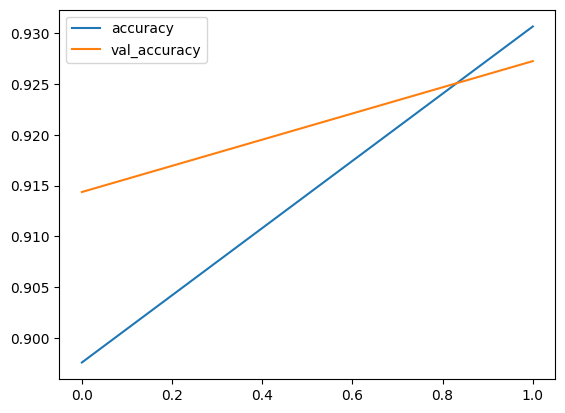

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()